In [2]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from data_loader import GetLoader
import numpy as np
from scipy import signal
from TCN_PPG import TemporalConvNet
import pytz
from datetime import datetime
from sklearn.model_selection import train_test_split
from torchinfo import summary
from bp_only_evid_train_fuc import train_loop, test_loop

In [3]:
train_dataset = np.load('./data/new_ppg_train.npy')

In [4]:
test_dataset = np.load('./data/new_ppg_test.npy')

In [5]:
X_train = train_dataset[:, :-6]
Y_train = train_dataset[:, -4:]

In [6]:
X_test = test_dataset[:, :-6]
Y_test = test_dataset[:, -4:]

In [7]:
train_time = train_dataset[:, -5]
test_time = test_dataset[:, -5]

In [8]:
X_train_id = train_dataset[:, -6]
X_test_id = test_dataset[:, -6]

In [9]:
label_target = ['hr', 'rr', 'sp', 'dp']
training_target = label_target[2]

In [10]:
Fs = 31.25

In [11]:
def filter_data(data, Fs, low, high, order):
    b, a = signal.butter(order, [low/(Fs * 0.5), high/(Fs * 0.5)], 'bandpass')
    # perform band pass filter
    filtered_data = signal.filtfilt(b, a, data)
    return filtered_data

In [12]:
def low_pass_filter(data, Fs, low, order):
    b, a = signal.butter(order, low/(Fs * 0.5), 'low')
    # perform low-pass filter
    filtered_data = signal.filtfilt(b, a, data)
    return filtered_data

In [13]:
print('===============================')
print('bandpass filter......')
cnt = 0
for i in range(X_train.shape[0]):
    X_train[i, :] = filter_data(X_train[i, :], Fs, 0.7, 15, 5)

bandpass filter......


In [14]:
print('===============================')
print('bandpass filter on test data......')
cnt = 0
for i in range(X_test.shape[0]):
    X_test[i, :] = filter_data(X_test[i, :], Fs, 0.7, 15, 5)

bandpass filter on test data......


In [15]:
from scipy.signal import find_peaks
from scipy.signal import resample

In [16]:
peaks_list_1 = []
peaks_list_2 = []
peaks_max = []

In [17]:
for i in range(X_train.shape[0]):
    peaks, _ = find_peaks(X_train[i, :], distance=15)
    peaks_list_1.append(peaks[4])
    peaks_list_2.append(peaks[6])
    peaks_max.append(peaks[5])

In [18]:
for i in range(len(peaks_list_1)):
    if peaks_list_2[i] - peaks_list_1[i] < 20:
        print(peaks_list_2[i])
        print(peaks_list_1[i])

In [19]:
ppg_1 = X_train[0, peaks_list_1[0]:peaks_list_2[0]]

In [20]:
ppg = resample(ppg_1, 64)

In [21]:
ppg = ppg.reshape(1,-1)

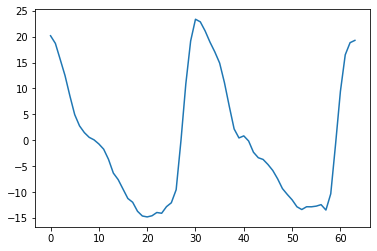

In [22]:
plt.plot(ppg[0, :])    

In [23]:
for i in range(X_train.shape[0]):
    segment_ppg = X_train[i, peaks_list_1[i]:peaks_list_2[i]]
    f_ppg = resample(segment_ppg, 64)
    f_ppg = f_ppg.reshape(1,-1)
    ppg = np.concatenate((ppg, f_ppg), axis=0)

In [24]:
ppg = ppg[1:, :]

In [25]:
X_train = ppg

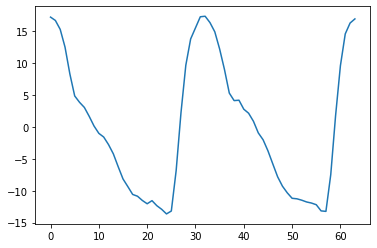

In [26]:
plt.plot(X_train[10, :])

In [27]:
peaks_list_1 = []
peaks_list_2 = []

In [28]:
peaks_max = []

In [29]:
for i in range(X_test.shape[0]):
    peaks, _ = find_peaks(X_test[i, :], distance=15)
    peaks_list_1.append(peaks[4])
    peaks_list_2.append(peaks[6])
    peaks_max.append(peaks[5])

In [30]:
ppg_1 = X_test[0, peaks_list_1[0]:peaks_list_2[0]]

In [31]:
ppg = resample(ppg_1, 64)

In [32]:
ppg = ppg.reshape(1,-1)

In [33]:
for i in range(X_test.shape[0]):
    segment_ppg = X_test[i, peaks_list_1[i]:peaks_list_2[i]]
    f_ppg = resample(segment_ppg, 64)
    f_ppg = f_ppg.reshape(1,-1)
    ppg = np.concatenate((ppg, f_ppg), axis=0)

In [34]:
ppg = ppg[1:, :]

In [35]:
X_test = ppg

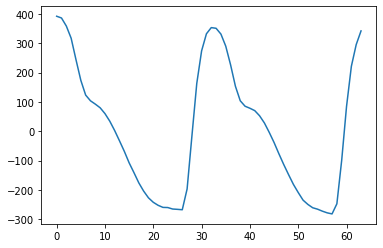

In [36]:
plt.plot(X_test[155, :])

In [37]:
X_train.shape

(14114, 64)

In [38]:
peaks, _ = find_peaks(X_train[111, :], distance=15)

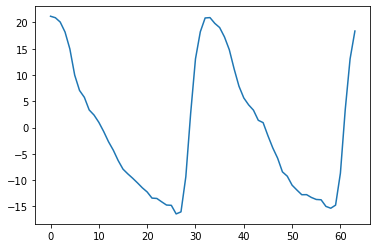

In [39]:
plt.plot(X_train[111, :])

In [40]:
print(peaks)

[33 53]


In [41]:
sbp = []
dbp = []
for i in range(X_train.shape[0]):
    peaks, _ = find_peaks(X_train[i, :], distance=15)
    sp = peaks[0]
    sbp.append(sp)
    dp = peaks[0]
    dbp.append(dp)

In [42]:
sbp_array = np.array(sbp)
dbp_array = np.array(dbp)

In [43]:
sbp_array = sbp_array.reshape(-1,1)
dbp_array = dbp_array.reshape(-1,1)

In [44]:
Y_train = np.concatenate((sbp_array, dbp_array), axis=1)
print(Y_train.shape)

(14114, 2)


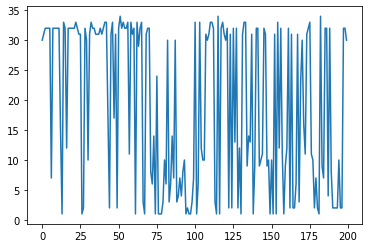

In [49]:
plt.plot(Y_train[:200, 0])

In [50]:
sbp = []
dbp = []
for i in range(X_test.shape[0]):
    peaks, _ = find_peaks(X_test[i, :], distance=15)
    sp = peaks[0]
    sbp.append(sp)
    dp = peaks[0]
    dbp.append(dp)

In [51]:
sbp_array = np.array(sbp)
dbp_array = np.array(dbp)

In [52]:
sbp_array = sbp_array.reshape(-1,1)
dbp_array = dbp_array.reshape(-1,1)

In [53]:
Y_test = np.concatenate((sbp_array, dbp_array), axis=1)
print(Y_test.shape)

(5383, 2)


In [54]:
#standardize data
print('===============================')
print('standardize data......')
X_train_mean = np.mean(X_train, axis = 1)
X_train_mean = np.reshape(X_train_mean, (-1,1))
X_train_std = np.std(X_train, axis = 1)
X_train_std = np.reshape(X_train_std, (-1,1))
X_train = (X_train - X_train_mean)/X_train_std

standardize data......


In [55]:
X_test_mean = np.mean(X_test, axis = 1)
X_test_mean = np.reshape(X_test_mean, (-1,1))
X_test_std = np.std(X_test, axis = 1)
X_test_std = np.reshape(X_test_std, (-1,1))
X_test = (X_test - X_test_mean)/X_test_std

In [ ]:
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# X_train[:, :] = sc.fit_transform(X_train[:, :])
# X_test[:, :] = sc.transform(X_test[:, :])

In [56]:
X_training = np.expand_dims(X_train, axis = -2)
X_testing = np.expand_dims(X_test, axis = -2)

In [57]:
# train_label = Y_train[:,2:]
# test_label = Y_test[:,2:]
train_label = Y_train
test_label = Y_test

In [58]:
training_data = GetLoader(X_training.astype(np.float32), train_label.astype(np.float32))
testing_data = GetLoader(X_testing.astype(np.float32), test_label.astype(np.float32))

In [59]:
batch_size = 32
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(testing_data, batch_size=batch_size)

In [ ]:
#start training
print('===============================')
print('start training......')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = TemporalConvNet(1, [64], kernel_size = [16, 16])
# model = network()
model.to(device)
# model.load_state_dict(checkpoint['model'])

In [ ]:
summary(model, (batch_size, X_training.shape[-2], X_training.shape[-1]), verbose = 1)
epochs = 1000
deep_evid_learning = 0
is_loss_MAE = 1
loss_fn = torch.nn.MSELoss()
metric_fn = torch.nn.L1Loss()

In [ ]:
for t in range(epochs):
    if t == 0:
        max_lr = 0.001
        iteration = 0
    if iteration > 40:
        iteration = 0
        max_lr *= 0.95
    else:
        iteration += 1
    Lr = 0.001
    print(f"Epoch {t+1} learning rate {Lr} \n-------------------------------")
    train_loop(train_dataloader, model, device,Lr, metric_fn, loss_fn, is_loss_MAE = is_loss_MAE)
    test_loop(test_dataloader, model, t, device, deep_evid_learning)
print("Done!")

In [60]:
#start predicting
print('===============================')
print('start predicting......')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
Lr = 0.00001
model = TemporalConvNet(1, [64], kernel_size = [16, 16])
model.to(device)
checkpoint = torch.load("ckpt_best_474_sp_2.35_dp_2.35.pth")
model.load_state_dict(checkpoint['model'], strict=False)

start predicting......


<All keys matched successfully>

In [62]:
time_stamp_training = []
time_stamp_testing = []

In [63]:
def epoch_time_local(epoch, zone):
    local_tz = pytz.timezone(zone)
    time = datetime.fromtimestamp(epoch).astimezone(local_tz).strftime("%Y-%m-%dT%H:%M:%S.%f")
    return time

In [64]:
#select data from training data
print('===============================')
print('get timetamp from training data......')
for i in range(X_train.shape[0]):
        time_stamp_training.append(epoch_time_local(train_time[i], 'US/Eastern'))

#select data from testing data
print('===============================')
print('get timetamp from testing data......')
for i in range(X_test.shape[0]):
        time_stamp_testing.append(epoch_time_local(test_time[i], 'US/Eastern'))

get timetamp from training data......
get timetamp from testing data......


visualize prediction......
MAE for SP: tensor(2.3497)
ME for SP: tensor(-0.4136)
Std for SP: tensor(4.2787)
MAE for DP: tensor(2.3493)
ME for DP: tensor(-0.4113)
Std for DP: tensor(4.2786)


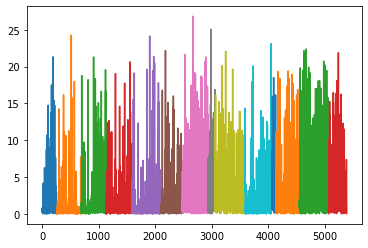

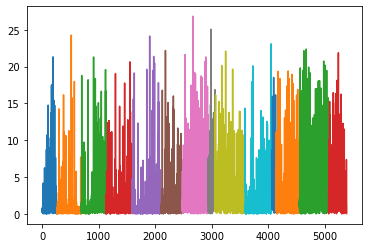

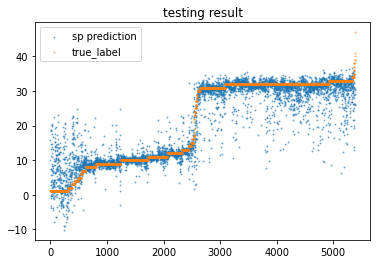

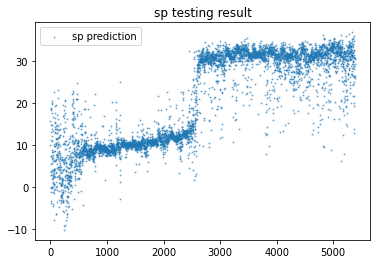

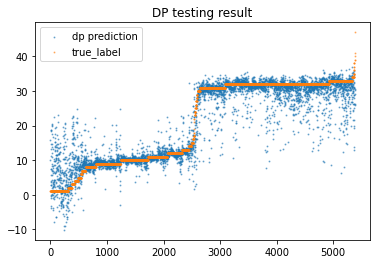

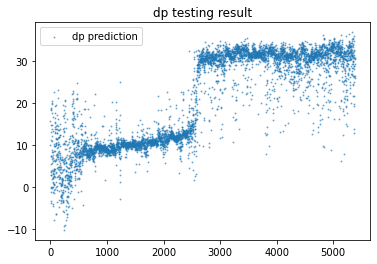

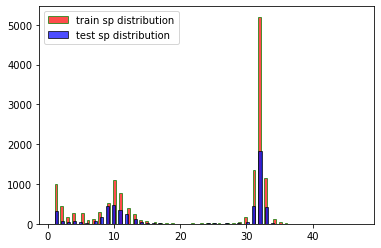

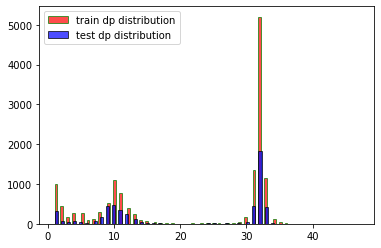

In [68]:
#visualize prediction
print('===============================')
print('visualize prediction......')
if_replace_label = 0
model.eval()
x_prediction = []
sp_pred = []
dp_pred = []
SP_AE = []
SP_E = []
DP_AE = []
DP_E = []
with torch.no_grad():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        sp, dp = model(X)
        for i in range(len(sp)):
            if if_replace_label:
                sp_pred_i = 2/3 * sp[i, 1] + dp[i, 1]
                sp_pred.append(sp_pred_i)
                SP_AE.append(abs(sp_pred_i - y[i,0]))
                SP_E.append(sp_pred_i - y[i,0])
                dp_pred_i = dp[i, 1] - (1/3 * sp[i, 1])
                dp_pred.append(dp_pred_i)
                DP_AE.append(abs(dp_pred_i - y[i,1]))
                DP_E.append(dp_pred_i - y[i,1])
            else:
                sp_pred.append(sp[i, 1])
                dp_pred.append(dp[i, 1])
                SP_AE.append(abs(sp[i, 1] - y[i,0]))
                SP_E.append(sp[i, 1] - y[i,0])
                DP_AE.append(abs(dp[i, 1] - y[i,1]))
                DP_E.append(dp[i, 1] - y[i,1])

person_segment_test = []
for i in range(len(time_stamp_testing)):
    if i == 0:
        individual_date = time_stamp_testing[0][:10]
        person_segment_test.append(i)
    if time_stamp_testing[i][:10] != individual_date:
        person_segment_test.append(i)
        individual_date =  time_stamp_testing[i][:10]

SP_AE = torch.tensor(SP_AE)
SP_E = torch.tensor(SP_E)
SP_MAE = torch.mean(SP_AE)
SP_ME = torch.mean(SP_E)
print('MAE for SP:', SP_MAE)
print('ME for SP:', SP_ME)
SP_std = torch.sqrt(torch.mean(SP_AE ** 2))
print('Std for SP:', SP_std)

plt.figure()
for i in range(len(person_segment_test)):
    if i == len(person_segment_test) -1 :
        person_lable = SP_AE[person_segment_test[i]:]
        plt.plot(list(range(person_segment_test[i], len(SP_AE))), person_lable)
    else:
        person_lable = SP_AE[person_segment_test[i]:person_segment_test[i+1]]
        plt.plot(list(range(person_segment_test[i], person_segment_test[i+1])), person_lable)

DP_AE = torch.tensor(DP_AE)
DP_E = torch.tensor(DP_E)
DP_MAE = torch.mean(DP_AE)
DP_ME = torch.mean(DP_E)
print('MAE for DP:', DP_MAE)
print('ME for DP:', DP_ME)
DP_std = torch.sqrt(torch.mean(DP_AE ** 2))
print('Std for DP:', DP_std)

plt.figure()
for i in range(len(person_segment_test)):
    if i == len(person_segment_test) -1 :
        person_lable = DP_AE[person_segment_test[i]:]
        plt.plot(list(range(person_segment_test[i], len(DP_AE))), person_lable)
    else:
        person_lable = DP_AE[person_segment_test[i]:person_segment_test[i+1]]
        plt.plot(list(range(person_segment_test[i], person_segment_test[i+1])), person_lable)

#sort label from small to large
sorted_id_test_sp = sorted(range(len(Y_test[:,0])), key=lambda k: Y_test[:,0][k])
sorted_id_test_dp = sorted(range(len(Y_test[:,1])), key=lambda k: Y_test[:,1][k])

# plot rr_pred_test vs test_lable
plt.figure()
plt.title(label = 'testing result')
# plt.plot(np.array(sp_pred)[sorted_id_test_sp], label = 'sp prediction')
# plt.plot(Y_test[:,2][sorted_id_test_sp], label = 'true_label')
plt.scatter(list(range(len(sp_pred))), np.array(sp_pred)[sorted_id_test_sp], s = 1, alpha=0.5, label = 'sp prediction')
plt.scatter(list(range(len(Y_test[:,0]))), Y_test[:,0][sorted_id_test_sp], s = 1, alpha=0.5, label = 'true_label')
plt.legend()
plt.show()

plt.figure()
plt.title(label = 'sp testing result')
# plt.plot(np.array(sp_pred)[sorted_id_test_sp], label = 'sp prediction')
plt.scatter(list(range(len(sp_pred))), np.array(sp_pred)[sorted_id_test_sp], s = 1, alpha=0.5, label = 'sp prediction')
plt.legend()
plt.show()

sp_error = abs(np.array(sp_pred)[sorted_id_test_sp] - Y_test[:,0][sorted_id_test_sp])

plt.figure()
plt.title(label = 'DP testing result')
# plt.plot(np.array(dp_pred)[sorted_id_test_dp], label = 'dp prediction')
# plt.plot(Y_test[:,3][sorted_id_test_dp], label = 'true_label')
plt.scatter(list(range(len(dp_pred))), np.array(dp_pred)[sorted_id_test_dp], s = 1, alpha=0.5, label = 'dp prediction')
plt.scatter(list(range(len(Y_test[:,1]))), Y_test[:,1][sorted_id_test_dp], s = 1, alpha=0.5, label = 'true_label')
plt.legend()
plt.show()


plt.figure()
plt.title(label = 'dp testing result')
# plt.plot(np.array(dp_pred)[sorted_id_test_dp], label = 'dp prediction')
plt.scatter(list(range(len(dp_pred))), np.array(dp_pred)[sorted_id_test_dp], s = 1, alpha=0.5, label = 'dp prediction')
plt.legend()
plt.show()

plt.figure()
plt.hist(Y_train[:,-2], bins=100, facecolor="red", edgecolor="green", alpha=0.7,
         label = 'train sp distribution')
plt.hist(Y_test[:,-2], bins=100, facecolor="blue", edgecolor="black", alpha=0.7,
         label = 'test sp distribution')
plt.legend()

plt.figure()
plt.hist(Y_train[:,-1], bins=100, facecolor="red", edgecolor="green", alpha=0.7,
         label = 'train dp distribution')
plt.hist(Y_test[:,-1], bins=100, facecolor="blue", edgecolor="black", alpha=0.7,
         label = 'test dp distribution')
plt.legend()